# Querying On-Disk Tables

> Objectives:
> * Compare queries of tabular data for **on-disk** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.023 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 30.113 MiB


## Load movielens datasets in pandas DataFrames

In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.023 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 30.137 MiB


In [3]:
# Import CSV files via pandas
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 71.184 MiB RAM in 0.475s, peaked 0.000 MiB above current, total RAM usage 101.320 MiB


In [4]:
# Store movies and ratings in 2 separate tables in SQLite
sqlite_norm = "movielens-norm.sqlite"
if os.path.exists(sqlite_norm):
    os.unlink(sqlite_norm)
import sqlite3
conn = sqlite3.connect(sqlite_norm)
conn.text_factory = str   # Shut up problems with Unicode
ratings.to_sql("ratings", conn)
movies.to_sql("movies", conn)
conn.close()

In [4] used 113.602 MiB RAM in 2.820s, peaked 122.570 MiB above current, total RAM usage 214.922 MiB


In [5]:
# create one merged DataFrame
lens = pd.merge(movies, ratings)

In [5] used 85.453 MiB RAM in 0.133s, peaked 0.000 MiB above current, total RAM usage 300.375 MiB


In [6]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [6] used 61.055 MiB RAM in 0.144s, peaked 0.000 MiB above current, total RAM usage 361.430 MiB


In [7]:
# Store lens denormalized in 1 table in SQLite
sqlite_denorm = "movielens-denorm.sqlite"
if os.path.exists(sqlite_denorm):
    os.unlink(sqlite_denorm)
conn_denorm = sqlite3.connect(sqlite_denorm)
conn_denorm.text_factory = str   # Shut up problems with Unicode
lens.to_sql("lens", conn_denorm)
conn_denorm.close()

In [7] used 46.098 MiB RAM in 3.348s, peaked 107.938 MiB above current, total RAM usage 407.527 MiB


In [8]:
# Get rid of unnecessary containers to save memory
del movies, ratings

In [8] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 407.527 MiB


In [9]:
%time result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 34.9 ms


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [9] used 0.129 MiB RAM in 0.043s, peaked 0.000 MiB above current, total RAM usage 407.656 MiB


In [10]:
# keep the run-time for reference
qtime_pandas_mem = mw.measurements.time_delta
qtime_pandas_mem

0.042758941650390625

In [10] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 407.656 MiB


## Querying on-disk data with SQLite (relational database)

In [11]:
# Execute the query with the de-normalized SQLite database
conn = sqlite3.connect(sqlite_denorm)
c = conn.cursor()

In [11] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 407.656 MiB


In [12]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
%time result = [r for r in c.execute(q)]

CPU times: user 104 ms, sys: 20 ms, total: 124 ms
Wall time: 124 ms
In [12] used 0.000 MiB RAM in 0.126s, peaked 0.000 MiB above current, total RAM usage 407.656 MiB


In [13]:
# keep the run-time for reference
qtime_sqlite_denorm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [13] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 407.656 MiB


In [14]:
# Execute the query with the normalized SQLite database
conn = sqlite3.connect(sqlite_norm)
c = conn.cursor()

In [14] used 0.004 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 407.660 MiB


In [15]:
q = """
select ratings.user_id from movies 
INNER JOIN ratings ON movies.movie_id = ratings.movie_id
where movies.title == 'Tom and Huck (1995)' and ratings.rating == 5
"""
%time result = [r for r in c.execute(q)]

CPU times: user 1.55 s, sys: 1.12 s, total: 2.66 s
Wall time: 2.67 s
In [15] used 0.000 MiB RAM in 2.672s, peaked 0.000 MiB above current, total RAM usage 407.660 MiB


In [16]:
# keep the run-time for reference
qtime_sqlite_norm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [16] used 0.023 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 407.684 MiB


So in general, we see that it is much faster to query tables in denormalized form, although they take much more storage:

In [17]:
!ls -lh $sqlite_norm $sqlite_denorm

-rw-r--r-- 1 francesc francesc 78M Nov 24 11:32 movielens-denorm.sqlite
-rw-r--r-- 1 francesc francesc 37M Nov 24 11:32 movielens-norm.sqlite
In [17] used 0.332 MiB RAM in 0.116s, peaked 0.000 MiB above current, total RAM usage 408.016 MiB


In some way, storing tables in normalized form is a kind of compression, but that comes to the cost of using more time to process queries.  Let's enter another way to compress denormalized data tables on-disk:

## bcolz

`bcolz` cannot only deal with data in-memory, but also on-disk using exactly the same API.  Let's try that.

In [18]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     0.12.1.dev2
NumPy version:     1.10.1
Blosc version:     1.4.1 ($Date:: 2014-07-08 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.4.4
Python version:    2.7.10 |Continuum Analytics, Inc.| (default, Oct 19 2015, 18:04:42) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
In [18] used 5.520 MiB RAM in 0.037s, peaked 0.000 MiB above current, total RAM usage 413.535 MiB


In [19]:
# Import a pandas DataFrame in a ctable on-disk
bcolz_dir = "movielens-denorm.bcolz"
if os.path.exists(bcolz_dir):
    import shutil
    shutil.rmtree(bcolz_dir)
zlens = bcolz.ctable.fromdataframe(lens, rootdir=bcolz_dir)

In [19] used 0.613 MiB RAM in 0.191s, peaked 1.195 MiB above current, total RAM usage 414.148 MiB


In [20]:
%time result = zlens["(title == b'Tom and Huck (1995)') & (rating == 5)"]['user_id']
result

CPU times: user 92 ms, sys: 20 ms, total: 112 ms
Wall time: 71 ms


array([  75, 3842, 6031])

In [20] used 0.012 MiB RAM in 0.075s, peaked 0.000 MiB above current, total RAM usage 414.160 MiB


In [21]:
# keep the run-time for reference
qtime_bcolz = mw.measurements.time_delta
# ...and print the result (for reference too)
result

array([  75, 3842, 6031])

In [21] used 0.023 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 414.184 MiB


In [22]:
# One can optimize the query more
%time result = [r.user_id for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]

CPU times: user 64 ms, sys: 16 ms, total: 80 ms
Wall time: 33.5 ms
In [22] used 0.016 MiB RAM in 0.035s, peaked 0.000 MiB above current, total RAM usage 414.199 MiB


In [23]:
# keep the run-time for reference
qtime_bcolz_opt = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [23] used 0.023 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 414.223 MiB


Let's see the space consumed on-disk:

In [24]:
!du -sh $bcolz_dir

6.6M	movielens-denorm.bcolz
In [24] used 0.008 MiB RAM in 0.116s, peaked 0.000 MiB above current, total RAM usage 414.230 MiB


and let's compare it with the internal estimated size:

In [25]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.89 MB; ratio: 19.45
  cparams := cparams(clevel=5, shuffle=True, cname='lz4')
  rootdir := 'movielens-denorm.bcolz'
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [25] used 0.031 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 414.262 MiB


So, the internal estimated size is a bit higher than the actual size on-disk, which means that bcolz offers a conservative guess in general.

Another interesting fact is that the de-normalized version of the ctable takes less space than the normalized version in a relational database, and the query speed is still faster (than SQLite at least).

But there are other ways to store compressed tables.  Let's visit PyTables and see how it performs.

## PyTables

In [26]:
h5denorm = "movielens-denorm.h5"
if os.path.exists(h5denorm):
    os.unlink(h5denorm)
zlens.tohdf5(h5denorm, nodepath='/h5lens')

In [26] used 0.770 MiB RAM in 0.386s, peaked 0.000 MiB above current, total RAM usage 415.031 MiB


In [27]:
import tables
h5file = tables.open_file(h5denorm)
h5lens = h5file.root.h5lens

In [27] used 0.031 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 415.062 MiB


In [28]:
# Let's have a look at the HDF5 table
h5lens

/h5lens (Table(1000209,), shuffle, blosc:lz4(5)) ''
  description := {
  "movie_id": Int64Col(shape=(), dflt=0, pos=0),
  "title": StringCol(itemsize=82, shape=(), dflt='', pos=1),
  "genres": StringCol(itemsize=47, shape=(), dflt='', pos=2),
  "user_id": Int64Col(shape=(), dflt=0, pos=3),
  "rating": Int64Col(shape=(), dflt=0, pos=4),
  "unix_timestamp": Int64Col(shape=(), dflt=0, pos=5)}
  byteorder := 'little'
  chunkshape := (1628,)

In [28] used 0.004 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 415.066 MiB


In [29]:
%time result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

CPU times: user 188 ms, sys: 12 ms, total: 200 ms
Wall time: 167 ms
In [29] used 0.020 MiB RAM in 0.169s, peaked 0.000 MiB above current, total RAM usage 415.086 MiB


In [30]:
# keep the run-time for reference
qtime_pytables = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [30] used 0.012 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 415.098 MiB


So, it seems that PyTables has a similar performance than SQLite for the queries (200 ms vs 170 ms for the denormalized case).  What about the size of the HDF5 file?

In [31]:
h5file.close()
!ls -lh $h5denorm

-rw-r--r-- 1 francesc francesc 6.5M Nov 24 11:32 movielens-denorm.h5
In [31] used 0.008 MiB RAM in 0.114s, peaked 0.000 MiB above current, total RAM usage 415.105 MiB


6.5 MB is very close to 6.6 MB that used bcolz (which is expected because both are using LZ4 as the compressor), and both are much less than pandas and SQLite.

Now, pandas comes with its own interface to PyTables via the HDFStore sub-package, and we are curious to see how it fares compared with the native PyTables approach.  Let's check that out.

## HDFStore (pandas HDF5 via PyTables)

In [32]:
h5pandas = "movielens-pandas.h5"
if os.path.exists(h5pandas):
    os.unlink(h5pandas)
from pandas import HDFStore
hdf = HDFStore(h5pandas, complevel=5, complib="blosc")
hdf.put('h5lens', lens, format='table', data_columns=True)

In [32] used -10.125 MiB RAM in 9.274s, peaked 119.711 MiB above current, total RAM usage 404.980 MiB


In [33]:
%time hdf.select('h5lens', where="(title == 'Tom and Huck (1995)') & (rating == 5)", columns=["user_id"])

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.9 ms


,user_id
5121,75
5164,3842
5187,6031


In [33] used 0.074 MiB RAM in 0.022s, peaked 0.000 MiB above current, total RAM usage 405.055 MiB


In [34]:
# keep the run-time for reference
qtime_pandas_hdf5 = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [34] used 0.027 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 405.082 MiB


As we can see, the time (26 ms) is almost 2x better than to the time that it takes the query on a pandas DataFrame in memory (44 ms).  What about the size on-disk?

In [35]:
hdf.close()

In [35] used 0.008 MiB RAM in 0.121s, peaked 0.000 MiB above current, total RAM usage 405.090 MiB


In [36]:
!ls -lh $h5pandas

-rw-r--r-- 1 francesc francesc 13M Nov 24 11:32 movielens-pandas.h5
In [36] used -0.117 MiB RAM in 0.114s, peaked 0.000 MiB above current, total RAM usage 404.973 MiB


Ok, so 13 MB is around 2x larger than a pure PyTables file with the same info (6.5 MB).  Where the overhead comes from?  Well, it turns out that pandas makes use of the indexing capabilities of PyTables automatically, so let's make PyTables to index the columns that participate in the query.

## Indexing (PyTables)

In [37]:
## Copy the original PyTables table into another file
import shutil
h5idx = "movielens-indexed.h5"
if os.path.exists(h5idx):
    os.unlink(h5idx)
shutil.copyfile(h5denorm, h5idx)

In [37] used 0.000 MiB RAM in 0.012s, peaked 0.000 MiB above current, total RAM usage 404.973 MiB


In [38]:
# Open the new file in 'a'ppend mode
h5i = tables.open_file(h5idx, mode="a")

In [38] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 404.973 MiB


In [39]:
# Create an index for the 'title' column
h5lens = h5i.root.h5lens
h5lens.cols.title.create_csindex()

1000209

In [39] used 0.004 MiB RAM in 3.967s, peaked 159.812 MiB above current, total RAM usage 404.977 MiB


In [40]:
# ...and redo the query...
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loops, best of 1: 12.9 ms per loop
In [40] used 0.012 MiB RAM in 0.020s, peaked 0.000 MiB above current, total RAM usage 404.988 MiB


In [41]:
# keep the run-time for reference
qtime_pytables_index1 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [41] used 0.020 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 405.008 MiB


So, by indexing one column we have got a 60x of acceleration wrt PyTables (5 ms vs 300 ms).  What happens if we index the 'rating' column?

In [42]:
h5lens.cols.rating.create_csindex()

1000209

In [42] used 0.000 MiB RAM in 0.668s, peaked 0.000 MiB above current, total RAM usage 405.008 MiB


In [43]:
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loops, best of 1: 1.73 ms per loop
In [43] used 0.016 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 405.023 MiB


In [44]:
# keep the run-time for reference
qtime_pytables_index2 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [44] used 0.000 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 405.023 MiB


Ok, that's another ~8x additional acceleration, and the best time that we ever reached for this query.

In [45]:
h5i.close()

In [45] used 0.000 MiB RAM in 0.079s, peaked 0.000 MiB above current, total RAM usage 405.023 MiB


## Indexing (SQLite)

We are of course curious to find out how indexing in relational databases fares against PyTables' own indexing.  Let's check that out:

In [46]:
sqlite_idx = "movielens-indexed.sqlite"
if os.path.exists(sqlite_idx):
    os.unlink(sqlite_idx)
shutil.copyfile(sqlite_denorm, sqlite_idx)
conn_idx = sqlite3.connect(sqlite_idx)

In [46] used -0.016 MiB RAM in 0.060s, peaked 0.000 MiB above current, total RAM usage 405.008 MiB


In [47]:
c = conn_idx.cursor()
c.execute("CREATE INDEX index_title ON lens (title)")
conn_idx.commit()

In [47] used 0.004 MiB RAM in 1.961s, peaked 0.000 MiB above current, total RAM usage 405.012 MiB


In [48]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]
# keep the run-time for reference
qtime_sqlite_index1 = t.best

1 loops, best of 1: 143 µs per loop
In [48] used 0.000 MiB RAM in 0.008s, peaked 0.000 MiB above current, total RAM usage 405.012 MiB


In [49]:
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [49] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 405.012 MiB


Wow, with quite less than 1 ms we are getting the best figure so far, and faster than the best figure with indexed PyTables.

## Exercise

What will happen if index the rating column?  We should get better speed, right?  Try it out and report the improvement that you are seeing.

### Solution

In [54]:
c.execute("CREATE INDEX index_rating ON lens (rating)")
conn_idx.commit()

In [54] used 0.000 MiB RAM in 1.087s, peaked 0.000 MiB above current, total RAM usage 384.457 MiB


In [56]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]

1 loops, best of 1: 130 ms per loop
In [56] used 0.000 MiB RAM in 0.133s, peaked 0.000 MiB above current, total RAM usage 384.457 MiB


Uh, we are getting far worse performance with 2 indexes. Take away lesson: indexing is a tricky thing and the best way to assess the improvement in performance is by trying it out, so do not blindly index everthing.

## Final performance comparison

In [50]:
%matplotlib inline

In [50] used -24.344 MiB RAM in 0.120s, peaked 26.566 MiB above current, total RAM usage 380.668 MiB


/home/francesc/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


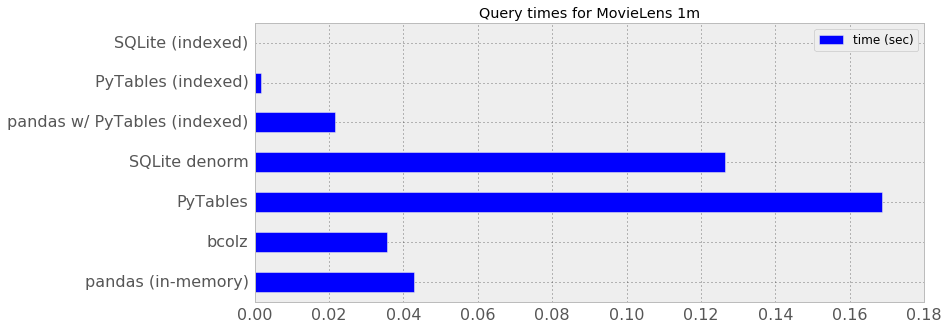

In [51] used 2.688 MiB RAM in 0.250s, peaked 0.000 MiB above current, total RAM usage 383.355 MiB


In [51]:
# Query times
labels = ["pandas (in-memory)", "bcolz", "PyTables", "SQLite denorm", "pandas w/ PyTables (indexed)", "PyTables (indexed)", "SQLite (indexed)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas_mem, qtime_bcolz_opt, qtime_pytables, qtime_sqlite_denorm, qtime_pandas_hdf5, qtime_pytables_index2, qtime_sqlite_index1]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m")

## Final size comparison

In [52]:
!du -sh movielens* | sort -n

5.8M	movielens-1m
6.5M	movielens-denorm.h5
6.6M	movielens-denorm.bcolz
11M	movielens-indexed.h5
13M	movielens-pandas.h5
37M	movielens-norm.sqlite
78M	movielens-denorm.sqlite
110M	movielens-indexed.sqlite
In [52] used -0.016 MiB RAM in 0.125s, peaked 0.016 MiB above current, total RAM usage 383.340 MiB


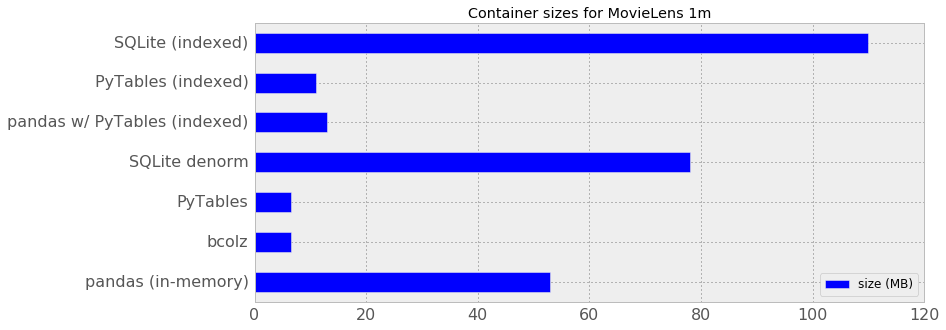

In [53] used 1.117 MiB RAM in 0.222s, peaked 0.000 MiB above current, total RAM usage 384.457 MiB


In [53]:
# Container sizes
df = pd.DataFrame({'size (MB)': [53, 6.6, 6.5, 78, 13, 11, 110]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

# Final Overview

Fortunately, there are many different solutions for storing large datasets both in-memory and on-disk.  Here it is a summary of the ones that we have seen in this tutorial:

* In-core
  * Python lists and dictionaries: Included in Python.  Very flexible.  Not efficient for large datasets.
  * NumPy: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * Pandas: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * bcolz: Good for large amounts of data, but reduced functionality.  Supports compression.
  
* Out-of-core
  * Pandas/HDFStore: Good for large datasets.  Supports indexing and compression.  Medium query speeds.
  * PyTables: Good for large datasets.  Supports indexing and compression.  Good query speeds.
  * bcolz: Good for large datasets.  Supports compression, but not indexing.  Medium query speeds.
  * SQLite: Can be used for large datasets, but requires lots of storage.  Supports indexing.  Excellent query speeds.

As you see, every solution has strengths and weaknesses, with wild variations in resource consumptions, so a wise thing to do is to know them better and try to apply the best candidate to your scenario.

Hope that helped and **enjoy data**.